In [1]:
%env DATASET_NAME=QPM_species
%env MODEL_NAME=resnet50_simclr

env: DATASET_NAME=QPM_species
env: MODEL_NAME=resnet50_simclr


In [2]:
import lightning.pytorch as pl
import numpy as np
import torch
import random
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers.wandb import WandbLogger
from pathlib import Path
from tqdm.auto import tqdm
from tsnecuda import TSNE

from config import Config, load_config
from datasets import get_data
from models import get_model

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# initialize the RNG deterministically
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

config = load_config()

In [4]:
# initialize data attributes and loaders
config.load_data()
config.print_labels()
dm = config.datamodule
assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
if len(config.ood) > 0:
    dm.setup("predict")

Dataset type train label type: species
Loaded 375443 images
Dataset type val label type: species
Loaded 48562 images
Dataset type test label type: species
Loaded 48790 images


In [6]:
model = config.get_model()

In [7]:
model_id = "tk88gzmy"
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", opt=config)
model = model.cuda()
model.eval()

wandb: Downloading large artifact model-tk88gzmy:best, 300.27MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:24.5


In [8]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

In [9]:
trn_embeddings = []
trn_labels = []
trn_strains = []

for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, s = batch
    x = x.float().cuda()
    y = y.long().cpu()
    s = s.long().cpu()
    proj_a, proj_b, logits = model(x)
    embedding = proj_a.detach().flatten(start_dim=1).cpu().numpy()
    trn_embeddings.extend(embedding)
    trn_labels.extend(y.detach().numpy())
    trn_strains.extend(s.detach().numpy())

val_embeddings = []
val_labels = []
val_strains = []

for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, s = batch
    x = x.float().cuda()
    y = y.long().cpu()
    s = s.long().cpu()
    proj_a, proj_b, logits = model(x)
    embedding = proj_a.detach().flatten(start_dim=1).cpu().numpy()
    val_embeddings.extend(embedding)
    val_labels.extend(y.detach().numpy())
    val_strains.extend(s.detach().numpy())

tst_embeddings = []
tst_labels = []
tst_strains = []

for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, s = batch
    x = x.float().cuda()
    y = y.long().cpu()
    s = s.long().cpu()
    proj_a, proj_b, logits = model(x)
    embedding = proj_a.detach().flatten(start_dim=1).cpu().numpy()
    tst_embeddings.extend(embedding)
    tst_labels.extend(y.detach().numpy())
    tst_strains.extend(s.detach().numpy())

100%|██████████| 382/382 [00:06<00:00, 55.96it/s]


In [10]:
trn_embeddings = np.array(trn_embeddings)
trn_labels = np.array(trn_labels)
trn_strains = np.array(trn_strains)
val_embeddings = np.array(val_embeddings)
val_labels = np.array(val_labels)
val_strains = np.array(val_strains)
tst_embeddings = np.array(tst_embeddings)
tst_labels = np.array(tst_labels)
tst_strains = np.array(tst_strains)
print(trn_embeddings.shape, val_embeddings.shape, tst_embeddings.shape)
print(trn_labels.shape, val_labels.shape, tst_labels.shape)
print(trn_strains.shape, val_strains.shape, tst_strains.shape)

(375443, 1024) (48562, 1024) (48790, 1024)
(375443,) (48562,) (48790,)
(375443,) (48562,) (48790,)


In [11]:
trn_embeddings_2d = TSNE(n_components=2, perplexity=100, random_seed=42).fit_transform(trn_embeddings)
print(trn_embeddings_2d.shape)

(375443, 2)


In [12]:
val_embeddings_2d = TSNE(n_components=2, perplexity=100, random_seed=42).fit_transform(val_embeddings)
print(val_embeddings_2d.shape)

(48562, 2)


In [13]:
tst_embeddings_2d = TSNE(n_components=2, perplexity=100, random_seed=42).fit_transform(tst_embeddings)
print(tst_embeddings_2d.shape)

(48790, 2)


In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


d1, d2 = trn_embeddings_2d.T
label = [config.labels[i] for i in trn_labels]
strain = [config.datamodule.strains[i] for i in trn_strains]
trn_data = pd.DataFrame(dict(x=d1, y=d2, label=label, strain=strain))

d1, d2 = val_embeddings_2d.T
label = [config.labels[i] for i in val_labels]
strain = [config.datamodule.strains[i] for i in val_strains]
val_data = pd.DataFrame(dict(x=d1, y=d2, label=label, strain=strain))

d1, d2 = tst_embeddings_2d.T
label = [config.labels[i] for i in tst_labels]
strain = [config.datamodule.strains[i] for i in tst_strains]
tst_data = pd.DataFrame(dict(x=d1, y=d2, label=label, strain=strain))

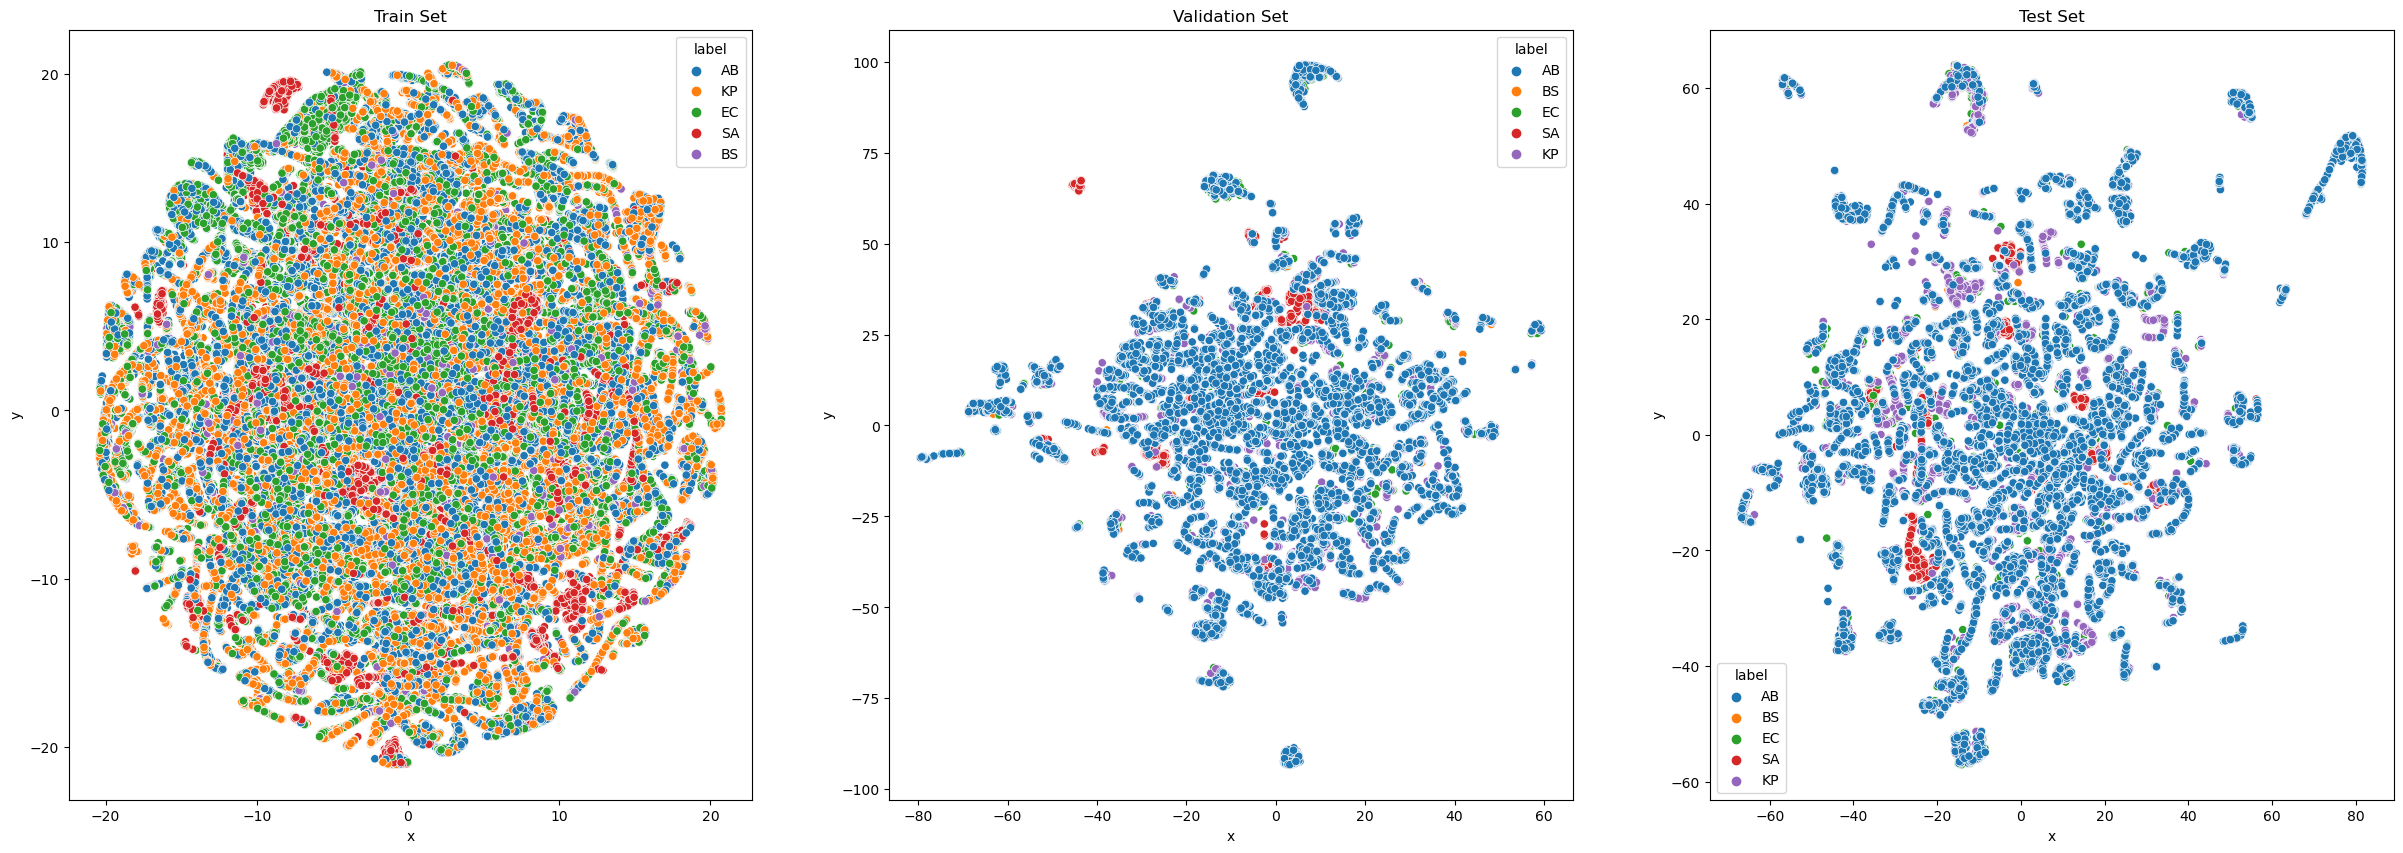

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

ax1.set_title("Train Set")
ax2.set_title("Validation Set")
ax3.set_title("Test Set")

sns.scatterplot(data=trn_data, x="x", y="y", hue="label", ax=ax1)
sns.scatterplot(data=val_data, x="x", y="y", hue="label", ax=ax2)
sns.scatterplot(data=tst_data, x="x", y="y", hue="label", ax=ax3)
plt.show()

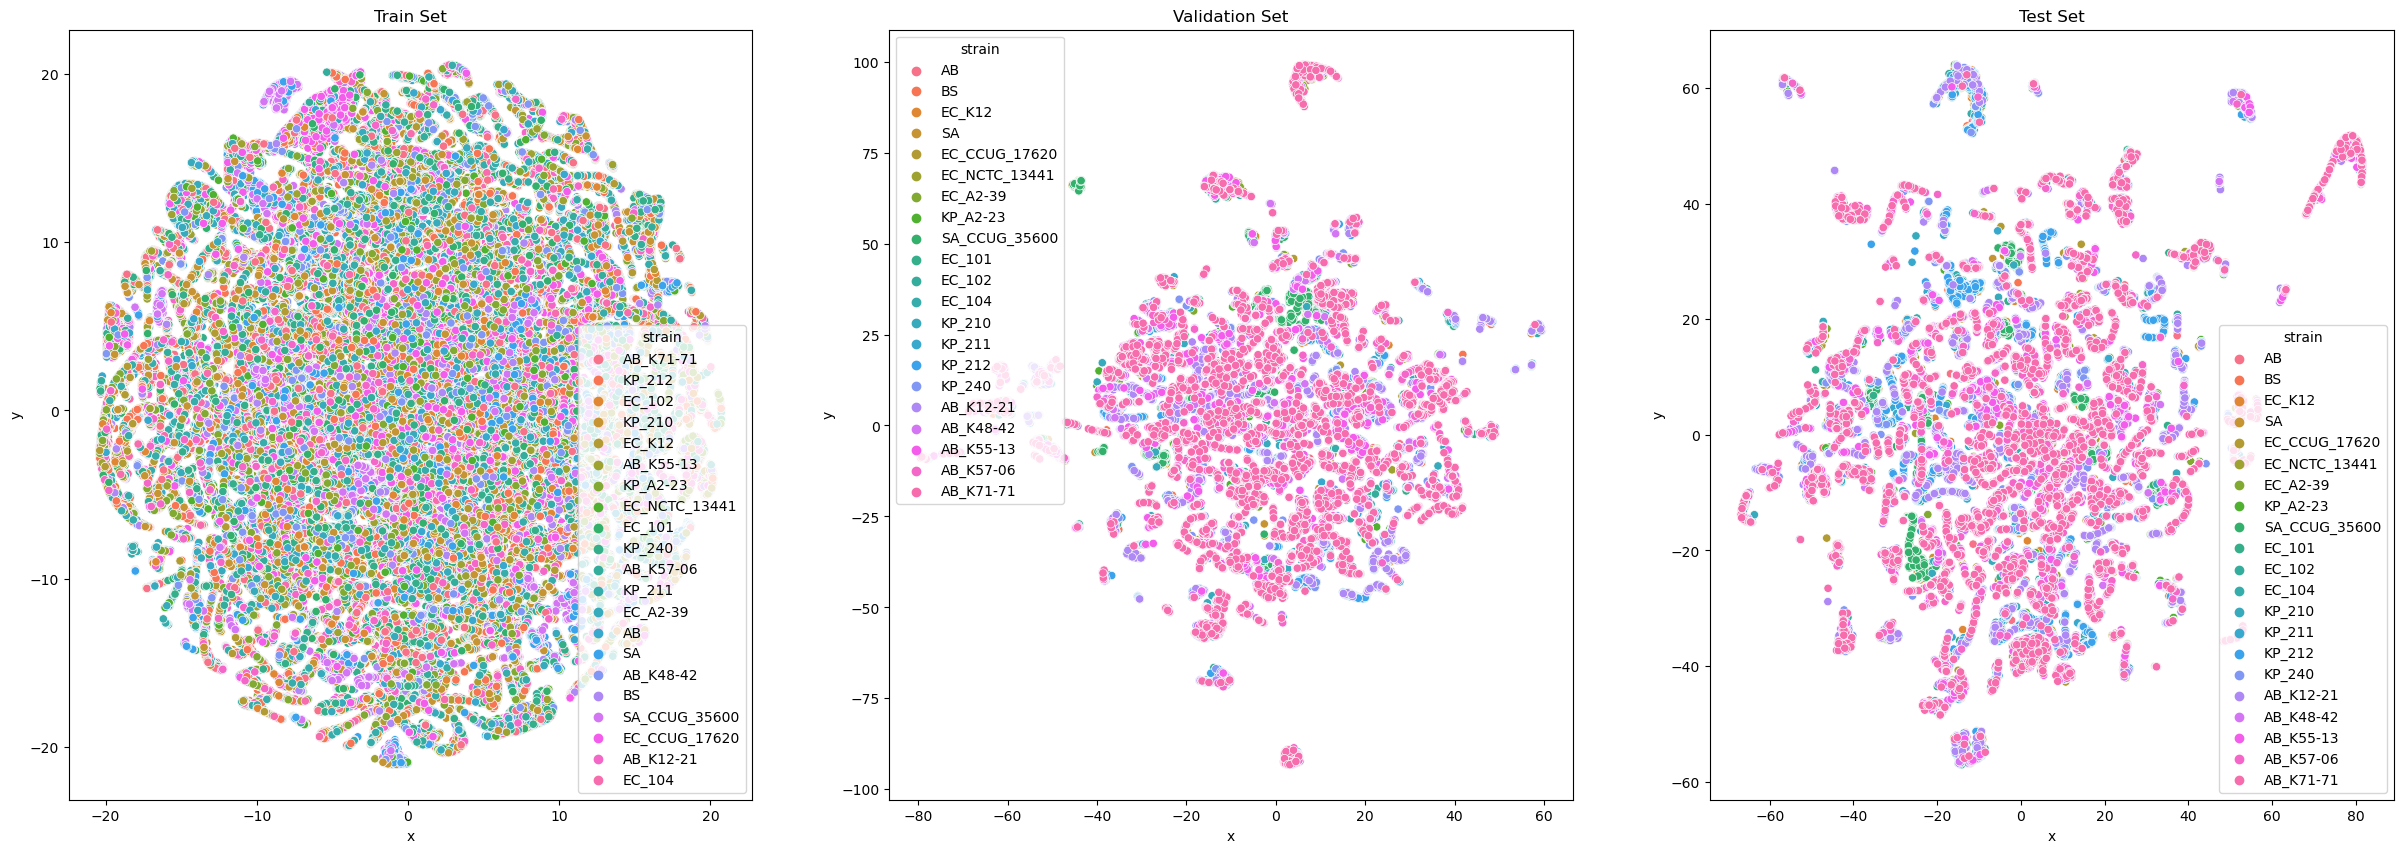

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

ax1.set_title("Train Set")
ax2.set_title("Validation Set")
ax3.set_title("Test Set")

sns.scatterplot(data=trn_data, x="x", y="y", hue="strain", ax=ax1)
sns.scatterplot(data=val_data, x="x", y="y", hue="strain", ax=ax2)
sns.scatterplot(data=tst_data, x="x", y="y", hue="strain", ax=ax3)
plt.show()

In [17]:
trn_dict = {}
for i in tqdm(range(21)):
    idxs = np.argwhere(trn_strains == i)
    trn_dict[i] = trn_embeddings[idxs].squeeze(1)
val_dict = {}
for i in tqdm(range(21)):
    idxs = np.argwhere(val_strains == i)
    val_dict[i] = val_embeddings[idxs].squeeze(1)
tst_dict = {}
for i in tqdm(range(21)):
    idxs = np.argwhere(tst_strains == i)
    tst_dict[i] = tst_embeddings[idxs].squeeze(1)

100%|██████████| 21/21 [00:00<00:00, 177.55it/s]


In [18]:
for k, v in tqdm(trn_dict.items()):
    np.save(f'assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}/train_{k}.npy', v)
for k, v in tqdm(val_dict.items()):
    np.save(f'assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}/val_{k}.npy', v)
for k, v in tqdm(tst_dict.items()):
    np.save(f'assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}/test_{k}.npy', v)

100%|██████████| 21/21 [00:02<00:00,  7.89it/s]
